# Action Balance Equation Fenics Test Notebook
## $\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_y N}{\partial y}  = S(x, y, t)$



## Manufactured Solution:
Goal is to test a solution that will numerically be similar to what we are actually doing in shallow water

Domain:

$\Omega = (0, L) \times (0,L)$

$L=1$

Assume:
(trying to be like dispersion relation ($c_g = c_p = \sqrt{gh}$)

$\textbf{c} = \{ \sqrt{1+x^2+y^2},\sqrt{1+x^2+y^2}\}$

$u=e^{t}\sin(c_1\pi x)\sin(c_2\pi y)$ 



Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial N}{\partial x} + \frac{\partial N}{\partial y}  = S(x, y, t)$



In [4]:
#import any necessary libraries in this block
from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import interpolate as interp
from scipy import integrate as integrate
from ufl import nabla_div
#from mayavi import mlab
%matplotlib inline
#define global variables
g=9.81
#define dummy stuff so functions can compile
mesh1=RectangleMesh(Point(0,0),Point(1,1),4,4)
V = FunctionSpace(mesh1, 'CG' , 1)

In [5]:

#all functions necessary to run this test case
def iterable(arr):
    '''Returns an iterable'''
    
    try:
        iter(arr)
        return arr
    except:
        return (arr,)


def expand_and_repeat(mtx, shape=None, repeat=None,
                      exist_dims=None, expand_dims=None):
    '''Expands matrix and repeats matrix contents along new dimensions
    Provide ``shape`` and ``exist_dims`` or ``expand_dims``, or
    ``repeat`` and ``expand_dims``.
    Parameters
    ----------
    mtx : numpy.ndarray
      Input matrix
    shape : tuple, optional
      Target shape of output matrix
    repeat : tuple or int, optional
      Repititions along new dimensions
    exist_dims : tuple or int, optional
      Indices of dimensions in target shape that are present in input matrix
    expand_dims : tuple or int, optional
      Indices of dimensions in target shape that are not present in input matrix
    Returns
    -------
    numpy.ndarray
      Matrix with target shape
    Examples
    --------
    >>> expand_and_repeat([[1,2,3],[4,5,6]], shape=(2,3,4), exist_dims=(0,1))
    >>> expand_and_repeat([[1,2,3],[4,5,6]], shape=(2,3,4), expand_dims=(2,))
    >>> expand_and_repeat([[1,2,3],[4,5,6]], shape=(2,3,4), expand_dims=2)
    >>> expand_and_repeat([[1,2,3],[4,5,6]], repeat=(4,), expand_dims=(2,))
    >>> expand_and_repeat([[1,2,3],[4,5,6]], repeat=4, expand_dims=2)
    '''
    
    mtx = np.asarray(mtx)
    
    if shape is not None:
        shape = iterable(shape)
        
        if mtx.ndim > len(shape):
            raise ValueError('Nothing to expand. Number of matrix '
                             'dimensions (%d) is larger than the '
                             'dimensionality of the target shape '
                             '(%d).' % (mtx.ndim, len(shape)))
        
        if exist_dims is not None:
            exist_dims = iterable(exist_dims)

            if len(exist_dims) != len(set(exist_dims)):
                raise ValueError('Existing dimensions should be unique.')
            
            if mtx.ndim != len(exist_dims):
                raise ValueError('Number of matrix dimensions (%d) '
                                 'should match the number of existing '
                                 'dimensions (%d).' % (mtx.ndim, len(exist_dims)))

            expand_dims = [i
                           for i in range(len(shape))
                           if i not in exist_dims]
                             
        elif expand_dims is not None:
            expand_dims = iterable(expand_dims)
            
            if len(expand_dims) != len(set(expand_dims)):
                raise ValueError('Expanding dimensions should be unique.')
            
            if len(shape) - mtx.ndim != len(expand_dims):
                raise ValueError('Dimensionality of the target shape '
                                 'minus the number of matrix dimensions '
                                 '(%d) should match the number of expanding '
                                 'dimensions (%d).' % (len(shape) - mtx.ndim, len(expand_dims)))
            
            exist_dims = [i
                          for i in range(len(shape))
                          if i not in expand_dims]
            
        else:
            raise ValueError('Target shape undetermined. Provide '
                             '``exist_dims`` or ``expand_dims``.')

        repeat = [n
                  for i, n in enumerate(shape)
                  if i in expand_dims]

        for i1, i2 in enumerate(exist_dims):
            if shape[i2] != mtx.shape[i1]:
                raise ValueError('Current matrix dimension (%d = %d) '
                                 'should match target shape (%d = %d).' % (i1, mtx.shape[i1], i2, shape[i2]))

    elif repeat is not None and expand_dims is not None:
        repeat = iterable(repeat)
        expand_dims = iterable(expand_dims)

        if len(expand_dims) != len(set(expand_dims)):
            raise ValueError('Expanding dimensions should be unique.')

        if len(repeat) != len(expand_dims):
            raise ValueError('Number of repititions (%d) should '
                             'match the number of expanding '
                             'dimensions (%d).' % (len(repeat), len(expand_dims)))
            
    else:
        raise ValueError('Target shape undetermined. Provide '
                         '``shape`` and ``exist_dims`` or '
                         '``expand_dims``, or ``repeat`` and ``expand_dims``.')

    for i, n in zip(expand_dims, repeat):
        mtx = np.expand_dims(mtx, i).repeat(n, axis=i)

    return mtx


def trapz_and_repeat(mtx, x, axis=-1):

    if axis < 0:
        axis += len(mtx.shape)

    return expand_and_repeat(np.trapz(mtx, x, axis=axis),
                             shape=mtx.shape, expand_dims=axis)


def jonswap(f,thetas, Hm0, Tp, gamma=3.3, sigma_low=.07, sigma_high=.09,
            g=9.81, method='yamaguchi', normalize=True,MDIR=0,MSInput=500,DSHAPL=2, out_option='tensor'):
    '''Generate JONSWAP spectrum
    Parameters
    ----------
    f : numpy.ndarray
        Array of radian frequencies
    Hm0 : float, numpy.ndarray
        Required zeroth order moment wave height
    Tp : float, numpy.ndarray
        Required peak wave period
    gamma : float
        JONSWAP peak-enhancement factor (default: 3.3)
    sigma_low : float
        Sigma value for frequencies <= ``1/Tp`` (default: 0.07)
    sigma_high : float
        Sigma value for frequencies > ``1/Tp`` (default: 0.09)
    g : float
        Gravitational constant (default: 9.81)
    method : str
        Method to compute alpha (default: yamaguchi)
    normalize : bool
        Normalize resulting spectrum to match ``Hm0``
    Returns
    -------
    E : numpy.ndarray
        Array of shape ``f, Hm0.shape`` with wave spectral densities
    '''

    # C Stringari - 04/06/2018
    # check input data types to avoid the following error:
    # ValueError: Integers to negative integer powers are not allowed.

    # raise an warning if the frequency array starts with zero. if the
    # user gives an array with zeros, the output will be inf at that
    # frequency
    
    #convert from radian to regular frequency
    f=f/(2*np.pi)
    if 0.0 in f:
        print('Frequency array contains zeros.')


    # Pierson-Moskowitz
    if method.lower() == 'yamaguchi':
        #print('yamaguchi method')
        alpha = 1. / (.06533 * gamma ** .8015 + .13467) / 16.
    elif method.lower() == 'goda':
        alpha = 1. / (.23 + .03 * gamma - .185 / (1.9 + gamma)) / 16.
    else:
        raise ValueError('Unknown method: %s' % method)

    E_pm = alpha * Hm0**2 * Tp**-4 * f**-5 * np.exp(-1.25 * (Tp * f)**-4)

    # JONSWAP
    sigma = np.ones(f.shape) * sigma_low
    sigma[f > 1./Tp] = sigma_high

    E_js = E_pm * gamma**np.exp(-0.5 * (Tp * f - 1)**2. / sigma**2.)

    if normalize:
        # axis=0 seems to work fine with all kinds of inputs
        #print("normalizing")
        #multiply by jacobian to get E as function of radial frequency
        E_js = E_js/(2*np.pi)* Hm0**2. / (16. * trapz_and_repeat(E_js, np.sort(f), axis=0))
    else:
        E_js=E_js/(2*np.pi)
        
    #now do directional spectrum
    #need to add following inputs
    #Mean direction (in degrees)
    #vector of thetas (in radians)
    #DSHAPL (directional shape)
    #MSinput (idk what it is)
    #MDIR=0
    #MSInput=3#500
    #thetas=np.linspace(-np.pi,np.pi,51)
    #DSHAPL=2
    
    NumThetaElem=thetas.size
    ADIR = MDIR*np.pi/180
    dtheta=(max(thetas)-min(thetas))/((NumThetaElem));
    if DSHAPL==1:
        DSPR = pi * MSInput / 180
        MS = max(DSPR**(-2) - 2, 1.0)
    else:
        MS = MSInput

    if (MS<12.0):
        CTOT = (2.0**MS) * (1.0)**2 / (pi * 2.0)
        #CTOT = (2.d0**MS) * (GAMMAfun(0.5d0*MS+1.d0))**2 / (PI * GAMMAfun(MS+1.d0))
    else:
        CTOT =  np.sqrt(0.5*MS/np.pi) / (1.0 - 0.25/MS)

 
      
    
    A_COS=np.cos(thetas-ADIR)
    CDIR = np.ones(thetas.shape) * CTOT * np.maximum(A_COS**MS, np.ones(thetas.shape)*(10**-10))
    CDIR[A_COS <= 0] = 0.0
    if out_option=='tensor':
        ACLOC = np.outer(CDIR ,E_js)# %!ACLOC(ID,IS) = CDIR * ACLOC(MDC,IS) 
    elif out_option=='vector':
        try:
            ACLOC=CDIR*E_js
        except:
            print('In order for vector output dimension of both input vectors must agree (thetas and sigmas)')
    
    return E_js,CDIR,ACLOC

def Jonswap_Expression(Hm0, Tp, gamma=3.3, sigma_low=.07, sigma_high=.09,
            g=9.81, normalize=True,MDIR=0,MSInput=500,DSHAPL=2, p_degree=7):
    '''Generate JONSWAP spectrum Expression for use in fenics, adapted from Jessica DG code
    Parameters
    ----------
    Note:
        Assumes x[0] is radian frequencies
    Hm0 : float, numpy.ndarray
        Required zeroth order moment wave height
    Tp : float, numpy.ndarray
        Required peak wave period
    gamma : float
        JONSWAP peak-enhancement factor (default: 3.3)
    sigma_low : float
        Sigma value for frequencies <= ``1/Tp`` (default: 0.07)
    sigma_high : float
        Sigma value for frequencies > ``1/Tp`` (default: 0.09)
    g : float
        Gravitational constant (default: 9.81)
    method : str
        Method to compute alpha (default: yamaguchi)
    normalize : bool
        Normalize resulting spectrum to match ``Hm0``
    Returns
    -------
    E : numpy.ndarray
        Array of shape ``f, Hm0.shape`` with wave spectral densities (for action density just divide by
        rel. rad. freq)
    '''
    FAC=1
    FPK=1.0/Tp
    FPK4=FPK**4
    SALPHA= ((Hm0**2) * (FPK4))/((0.06533*(gamma**0.8015)+0.13467)*16)
    SF=Expression('x[0]/(2*pi)',degree=p_degree)
    SF4=Expression('pow(SF,4)', degree=p_degree, SF=SF)
    SF5=Expression('pow(SF,5)', degree=p_degree, SF=SF)
    CPSHAP =Expression('1.25*FPK4/SF4',degree=p_degree,FPK4=FPK4,SF4=SF4)
    RA=Expression('CPSHAP > 10.0 ? 0.0: (SALPHA/SF5)*exp(-CPSHAP)', 
                  degree=p_degree, SALPHA=SALPHA, SF5=SF5, CPSHAP=CPSHAP)
    COEFF= Expression('SF <= fpeak ? sigmaa: sigmab', 
                      degree=p_degree, SF= SF, fpeak=FPK, sigmaa=sigma_low, sigmab=sigma_high)
    APSHAP = Expression('0.5*pow((SF-FPK)/(COEFF*FPK),2)',
                       degree=p_degree, SF=SF, FPK=FPK, COEFF=COEFF)
    SYF = Expression('APSHAP > 10.0 ? 1.0: pow(gamma,exp(-APSHAP))',
                    degree=p_degree, APSHAP=APSHAP, gamma=gamma)
    
    E_js = Expression('SYF*RA/(2*pi)', degree=p_degree, SYF=SYF, RA=RA)
    
    
    ADIR = MDIR*np.pi/180
    
    #dtheta=(max(thetas)-min(thetas))/((NumThetaElem))
    
    if DSHAPL==1:
        DSPR = pi * MSInput / 180
        MS = max(DSPR**(-2) - 2, 1.0)
    else:
        MS = MSInput

    if (MS<12.0):
        CTOT = (2.0**MS) * (1.0)**2 / (np.pi * 2.0)
        #CTOT = (2.d0**MS) * (GAMMAfun(0.5d0*MS+1.d0))**2 / (PI * GAMMAfun(MS+1.d0))
    else:
        CTOT =  np.sqrt(0.5*MS/np.pi) / (1.0 - 0.25/MS)

 
      
    
    A_COS=Expression('cos(x[1]-ADIR)',degree=p_degree,ADIR=ADIR)
    CDIR = Expression( 'A_COS>0 ? CTOT * max(pow(A_COS,MS), pow(10,-10)) : 0',
                      degree=p_degree,CTOT=CTOT,A_COS=A_COS,MS=MS)
    E = Expression('CDIR*E_js',degree=p_degree,CDIR=CDIR,E_js=E_js)
    
    
    return E
#need a function to calculate wave speed (phase and group) and wavenumber

def calc_wavenumber(sigmas,depth,g=9.81):
    #takes in np.array of relative, radian frequencies
    #outputs corresponding np.array of wavenumbers using
    #approximation to dispersion relationship from Hol.
    #Inputs:
    #sigmas - np.array floats of relative radian frequency
    #depth - float total water depth in meters
    #optional g, acceleration of gravity default at 9.81
    alpha=(sigmas**2)*depth/g
    beta=alpha*(np.tanh(alpha)**(-0.5))
    k=(alpha + (beta**2)*(np.cosh(beta)**(-2)))/(depth*(np.tanh(beta)+beta*(np.cosh(beta)**(-2))))
    return k
def calc_wavespeeds(k,depth,g=9.81):
    #calculates phase speed and group velocity given wavenumber and depth
    #from Hol. p127
    #FENICS Expression version below
    #n = Expression('0.5*(1.0+(2.0*k*depth)/(sinh(2.0*k*depth)))',degree=3, k=k, depth=H)
    #c = Expression('sqrt(g/k*tanh(k*depth))',degree=3,g=g,k=k,depth=H)
    #c_g=Expression('n*c',degree=3,n=n,c=c)
    
    #Inputs:
    #k - np.array of floats where each entry is a wavenumber
    #depth - float that is total water depth in meters
    # optional g- 9.81
    #Outputs
    #c- phase speed in np.array same dimension as k
    #c_g - group velocity same size as c
    
    n= 0.5*(1+2*k*depth/(np.sinh(2.0*k*depth)))
    c= np.sqrt(g/k*np.tanh(k*depth))
    c_g=n*c
    return c,c_g
def calc_c_sigma_theta(sigmas,thetas,k,depths,c_g,currents,z_coords,loc_num):
    ##Inputs
    #sigmas - takes in a vector of sigma values (sigma coordinate at each d.o.f) at one point in physical spaxe
    #thetas - corresponding theta in radians
    #k - wavenumber corresponding to the given sigmas and thetas
    #c_g - corresponding group velocity
    #(note sigmas, thetas,k,c_g should all be same length which is number of d.o.f in one 2D slice)
    #depths - depths in meters of ALL physical coordinates (not just current one)
    #z_coords - unique coordinates in physical space (not just current one)
    #currents - water velocity at ALL physical coordinates
    #loc_num - the number of the physical point (starts at 0)
    #(note depths,z_coords,currents should all be same length which is the number of unique points in physical space)
    ##Outputs
    #outputs a vector same size as sigmas that is the c_sigma at all d.o.f in ONE 2D slice 
    #of the 3D domain corresponding to a single point in physical space for c_theta and c_sigma
    
    #for now assuming H is constant in time but can fix this later
    dHdt=0.0
    dHdy = 0.0
    dudy = 0.0
    dvdx = 0.0 #migh not have to be 0, well see
    dvdy = 0.0
    
    #also going to assume v is zero but maybe can change this later
    v=0.0
    u=currents[loc_num]
    H=depths[loc_num]
    #calc gradient of H w.r.t. x
    if loc_num == 0:
        dHdx =(depths[loc_num+1]-H)/(z_coords[loc_num+1]-z_coords[loc_num])
        dudx = (currents[loc_num+1]-u)/(z_coords[loc_num+1]-z_coords[loc_num])
    elif loc_num == len(z_coords)-1:
        dHdx = (H-depths[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
        dudx = (u-currents[loc_num-1])/(z_coords[loc_num]-z_coords[loc_num-1])
    else:
        dHdx = (depths[loc_num+1]-depths[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
        dudx = (currents[loc_num+1]-currents[loc_num-1])/(z_coords[loc_num+1]-z_coords[loc_num-1])
    
    
    #now calculate velocity vectors
    c_sigma = k*sigmas/(np.sinh(2*k*H)) *(dHdt + u*dHdx + v*dHdy) - c_g*k*(dudx*(np.cos(thetas)**2) \
        + dudy*np.cos(thetas)*np.sin(thetas) + dvdx*np.sin(thetas)*np.cos(thetas)+dvdy*(np.sin(thetas)**2))
    c_theta = sigmas/(np.sinh(2*k*H))*(dHdx*np.sin(thetas)- dHdy*np.cos(thetas)) + \
        dudx*np.cos(thetas)*np.sin(thetas) - dudy*(np.cos(thetas)**2) + dvdx*(np.sin(thetas)**2) \
        -dvdy*np.cos(thetas)*np.sin(thetas)
    return c_sigma,c_theta


#also a function to take dof to a meshgrid for plotting
def dof_2_meshgrid_indeces(dofs):
    #takes in list of degrees of freedom, outputs list of array coordinates
    #each dof corresponds to in meshgrid
    num_col=len(np.unique(dofs[:,0]))
    num_row=len(np.unique(dofs[:,1]))
    #print(num_row)
    #print(num_col)
    Matrix_indeces=np.zeros(dofs.shape)
    new_indeces=np.argsort(dofs[:,0])
    #create input to save
    input_array=np.zeros(new_indeces.shape)
    dum=0
    for a in range(len(input_array)):
        input_array[a]=dum
        if (a+1)%num_row==0:
            dum=int(dum+1)
    #set indeces for columns
    Matrix_indeces[new_indeces,1]=input_array
    
    #now do same for row numbers
    new_indeces=np.argsort(dofs[:,1])
    dum=0
    for a in range(len(input_array)):
        input_array[a]=dum
        if (a+1)%num_col==0:
            dum=int(dum+1)
    Matrix_indeces[new_indeces,0]=input_array
    return Matrix_indeces

#lastly take a set of matrix indeces and create a matrix
def indeces_to_meshgrid(dof,Matrix_indeces):
    #allocate output array
    num_row=np.amax(Matrix_indeces[:,0])+1
    num_col=np.amax(Matrix_indeces[:,1])+1
    out_array=np.zeros((int(num_row),int(num_col)))
    
    ctr=0
    for a in dof:
        out_array[int(Matrix_indeces[ctr,0]),int(Matrix_indeces[ctr,1])]=a
        ctr=ctr+1
    return out_array

#turn a meshgrid matrix back to a dof vector given the Matrix_indeces
def meshgrid_to_dof(array_shape,Matrix_indeces):
    #expects 2d array
    out_len=(array_shape.shape[0]*array_shape.shape[1])
    dof_out=np.zeros(out_len)
    for a in range(out_len):
        dof_out[a]=array_shape[int(Matrix_indeces[a,0]),int(Matrix_indeces[a,1])]
    return dof_out

#get the indeces from the d.o.f. of the 2d slices along the 3rd dimension in a BlockMesh
#get the indeces from the d.o.f. of the 2d slices along the 3rd dimension in a BlockMesh
#each row is the indeces along a slice
def blockmesh_slice_indeces(dof_z):
    slice_coords=np.unique(dof_z) #returns sorted list of unique z coordinates
    slice_indeces=np.zeros((len(slice_coords),int(len(dof_z)/len(slice_coords))))

    ctr=0
    for n in slice_coords:
        slice_indeces[ctr,:]=(np.argwhere(dof_z==n).squeeze())
        ctr=ctr+1
    slice_indeces=slice_indeces.astype(int)
    return slice_indeces

#now let's see if we can calculate something like Hs
#function that takes in a 2D slice and the corresponding dof then integrates over 2D using trapezoidal rule
def calc_double_int(E,mini_sigma,mini_theta,Matrix_indeces):
    E2=indeces_to_meshgrid(E,Matrix_indeces)
    m0=integrate.trapz([integrate.trapz(E_x,mini_sigma) for E_x in E2],mini_theta )
    return m0

#Source terms
def calc_S_in(sigmas,thetas,E,U_mag,theta_wind,c,g=9.81):
    #######################################################
    #S_in
    #Source term for wind input, from SWAN
    #Inputs
    #sigmas - vector np.array of sigma at each computational point (rn it is radian freq)
    #thetas - in radians
    #E - np.array vector with the given variance density spectrum (may want to switch to action density later)
    #U_mag - magnitude of wind 10 m above surface in m/s, just a float right now (need to add direction)
    #c - phase speed, should be same dimension as E
    #optional g - gravity
    
    #parameters that shouldn't change
    rho_a=1.225 #denisty of air at STP (could make this more sophisticated later on)
    rho_w=1000 #density of water
    
    
    C_d=1.2875*(10**(-3)) if U_mag < 7.5 else (0.8+0.065*U_mag)*(10**(-3))
    U_fric = np.sqrt(C_d*(U_mag**2))
    sigmapm=0.13*g*2*np.pi/(28*U_fric)
    H=np.exp(-(sigmas/sigmapm)**4)
    #Expression version for FENICS
    #A = Expression('1.5*pow(10,-3)/(2*pi*pow(g,2))*pow(U_fric,4)*exp(-pow(x[0]/(2*pi*0.13*g/(28*U_fric)),-4))'
    #               ,degree=p_degree, U_fric=U_fric, g=g)
    #B = Expression('max(0.0,0.25*rho_a/rho_w*(28*U_fric/c_ph-1))*x[0]',
    #               degree=p_degree,rho_a=rho_a,rho_w=rho_w,U_fric=U_fric,c_ph=c) 
    A = 1.5*10**(-3)/(2*np.pi*g**2)*(U_fric*np.maximum(0,np.cos(thetas-theta_wind)))**4*H
    B= np.maximum(np.zeros(c.shape),0.25*rho_a/rho_w*(28*U_fric/c*np.cos(thetas-theta_wind)-1))*sigmas
    S_in= A + B*E
    return S_in

def calc_S_wc(sigmas,thetas,k,E):
    #########################################################
    #S_wc - whitecapping
    #follows WAM Cycle III formulation (see swantech manual)
    
    #Inputs:
    #sigmas - numpy array of the relative radian frequency of each d.o.f
    #k - wavenumber corresponding to each sigma
    #E - right now spectral density at each d.o.f but maybe change to action density (be careful!)
    
    #Output:
    #S_wc - numpy array same size as E with the spectral density per unit time 
    
    #constant
    C_ds = 2.36*(10**(-5))
    n_wc = 0.0
    p_wc=4
    mean_spm=np.sqrt(3.02*(10**(-3)))
    
    #need to calculate 0 moment and other integral quantities
    #Note: watch out for how this behaves !!!
    #m0=assemble(E*dx(mesh1)) <-- Fenics version
    #mean_k=(1/m0*assemble(k1**(-0.5)*E*dx(mesh1)))**(-2) <-- Fenics version
    #omega_exp=Expression('x[0]',degree=1)
    #omega1=project(omega_exp,V)
    #mean_omega=(1/m0*assemble(omega1**(-1.0)*E*dx(mesh1)))**(-1) <--Fenics version
    
    #m0=np.trapz(E,sigmas) <--- has issues so try this instead, probably innificient
    #mean_k=(1/m0*np.trapz(k**(-0.5)*E,sigmas))**(-2)
    #mean_omega=(1/m0*np.trapz(sigmas**(-1)*E,sigmas))**(-1)
    
    
    ######################
    #Integrating using fenics (only works if mesh1, V are 2D)
    #B=Function(V)
    #B.vector()[:] = E
    #E_fenics=interpolate(B,V)
    
    #B.vector()[:]=k
    #k_fenics=interpolate(B,V)
    #plot(k_fenics)
    #something is going wrong here!
    #B=Function(V)
    #B.vector()[:]=sigmas
    #sigmas_fenics=interpolate(B,V)
    #plot(sigmas_fenics)
    #m0=assemble(E_fenics*dx(mesh1))
    #print(m0)
    #mean_k=(1/m0*assemble(k_fenics**(-0.5)*E_fenics*dx(mesh1)))**(-2)
    #print(mean_k)
    
    #this isn't working for some reason
    #mean_omega=(1/m0*assemble(sigmas_fenics**(-1.0)*E_fenics*dx(mesh1)))**(-1)
    #print(mean_omega)
    
    #workaround
    #B=Function(V)
    #B.vector()[:] = E/sigmas
    #dum=interpolate(B,V)
    #plot(dum)
    #mean_omega=(1/m0*assemble(dum*dx(mesh1)))**(-1)
    #print(mean_omega)
    ###########################
    
    #Manual integration should work for 3D
    dof=np.zeros((len(sigmas),2))
    dof[:,0]=sigmas
    dof[:,1]=thetas
    Matrix_indeces=dof_2_meshgrid_indeces(dof)
    mini_sigma=np.unique(sigmas)
    mini_thets=np.unique(thetas)#indeces_to_meshgrid(thets,Matrix_indeces)[:,0]
    m0=calc_double_int(E,mini_sigma,mini_thets,Matrix_indeces)
    mean_k=(1/m0*calc_double_int(k**(-0.5)*E,mini_sigma,mini_thets,Matrix_indeces))**(-2)
    mean_omega=(1/m0*calc_double_int(sigmas**(-1.0)*E,mini_sigma,mini_thets,Matrix_indeces))**(-1)
    #print(m0)
    #print(mean_k)
    #print(mean_omega)
    
    
    
    mean_steepness=mean_k*np.sqrt(m0)
    Steepness = C_ds*((1-n_wc) + n_wc*(k/mean_k))*((mean_steepness/mean_spm)**(p_wc))
    
    S_wc = -Steepness*mean_omega*k/mean_k*E
    return S_wc

def calc_S_bfr(sigmas,k,E,depth,g=g):
    ##########################################################
    #S_bfr (bottom friction)
    #seems only relevant in very shallow water (see swantech manual)
    #Inputs
    #sigmas - numpy array of rel. radian frequencies, should correspond to d.o.f in E
    #k - wavenumber, same configuration as sigmas
    #E - numpy array of spectral density, should correspond to d.o.f same as k and sigmas
    #depth- local water depth in meters
    #Outputs
    #S_br - numpy array same size as E with spectral density per unit time
    
    C_bfr=0.067
    #S_bfr=Expression('-C_bfr/g*pow(x[0]/sinh(k*d),2)*E',degree=p_degree, C_bfr=C_bfr,g=g,k=k,d=H,E=E) <- Fenics ver.
    #S_bfr=project(S_bfr,V)
    S_bfr=-C_bfr/(g**2)*(sigmas/np.sinh(k*depth))**2*E
    return S_bfr

def calc_S_dsbr(sigmas,thetas,E,depth):
    #########################################################
    #S_dsbr
    #depth induced wave breaking
    
    #Inputs
    #sigmas
    #E
    #optional (need them but assuming named mesh1 and V)
    
    alpha_bj=1
    
    ###########################################
    #fenics version, doesn't work for 2d slice
    #B=Function(V)
    #B.vector()[:] = E
    #E_fenics=interpolate(B,V)
    #B=Function(V)
    #B.vector()[:]=sigmas
    #sigmas_fenics=interpolate(B,V)
    #m0=assemble(E_fenics*dx(mesh1))
    #print(m0)
    #mean_sigma = 1/m0*assemble(E_fenics*sigmas_fenics*dx(mesh1))
    #print(mean_sigma)
    
    ###########################################
    #manual integration, works on 2d slices
    dof=np.zeros((len(sigmas),2))
    dof[:,0]=sigmas
    dof[:,1]=thetas
    Matrix_indeces=dof_2_meshgrid_indeces(dof)
    mini_sigma=np.unique(sigmas)
    mini_thets=np.unique(thetas)#indeces_to_meshgrid(thets,Matrix_indeces)[:,0]
    m0=calc_double_int(E,mini_sigma,mini_thets,Matrix_indeces)
    mean_sigma=(1/m0*calc_double_int(sigmas*E,mini_sigma,mini_thets,Matrix_indeces))
    #print(m0)
    
    Hrms=np.sqrt(8*m0)
    H_max=0.73*depth
    beta=Hrms/H_max
    #print(beta)
    Q_0=0 if beta <= 0.5 else (2*beta-1)**2 if beta <=1 else 1
    num1=Q_0-(np.exp((Q_0-1)/(beta**2)))
    dem1=beta**2-(np.exp((Q_0-1)/(beta**2)))
    dum=Q_0-(beta**2)*(num1)/(dem1)
    Qb=0 if beta<0.2 else dum if beta <1 else 0.5
    print(Qb)
    
    
    S_dsbr=-alpha_bj*Qb*mean_sigma*E/(beta**2*np.pi)
    return S_dsbr

def calc_S_nl3(sigmas,thetas,k,E,d,g=9.81):
    #Calculates non-linear triad wave interactions using LTA approximation
    #(only should be calculated in shallow water)
    #Inputs
    #d - depth in meters
    alpha_eb=0.1;
    
    ######################################
    #This works for fenics but on whole domain only
    #if doing 2d slices of 3d domain this won't work
    #calculate integral factors
    #B=Function(V)
    #B.vector()[:] = E
    #E_fenics=interpolate(B,V)
    #B.vector()[:]=sigmas
    #sigmas_fenics=interpolate(B,V)
    #m0=assemble(E_fenics*dx(mesh1))
    #m1 = assemble(E_fenics*sigmas_fenics*dx(mesh1))
    
    
    ###########################################
    #manual integration, works on 2d slices
    dof=np.zeros((len(sigmas),2))
    dof[:,0]=sigmas
    dof[:,1]=thetas
    Matrix_indeces=dof_2_meshgrid_indeces(dof)
    mini_sigma=np.unique(sigmas)
    mini_thets=np.unique(thetas)#indeces_to_meshgrid(thets,Matrix_indeces)[:,0]
    m0=calc_double_int(E,mini_sigma,mini_thets,Matrix_indeces)
    m1=calc_double_int(sigmas*E,mini_sigma,mini_thets,Matrix_indeces)
    
    Hs=4*sqrt(m0)
    Tm01=m0/m1
    Ur=(g*Hs*Tm01**2)/(8*np.sqrt(2)*np.pi**2*d**2)
    
    
    sigma_half=sigmas/2

    #need to calculate wavenumbers for sigma_half
    k_half=calc_wavenumber(sigma_half,d)

    #also need wavespeed for sigma_half, sigma
    c_half,cg_half=calc_wavespeeds(k_half,d)
    c,cg=calc_wavespeeds(k,d)
    

    #interaction coefficient
    J= (k_half**2 *(g*d+2*c_half**2))/(k*d*(g*d+2.0/15.0*g*d**3*k**2-2/5*sigmas**2*d**2))
    
    #interpolate
    #need to convert to regular grid
    SIGS=indeces_to_meshgrid(sigmas,Matrix_indeces)
    THETS=indeces_to_meshgrid(thetas,Matrix_indeces)
    E2=indeces_to_meshgrid(E,Matrix_indeces)
    #1-D version
    #f=interp.interp1d(sigmas,E,fill_value=0,bounds_error=False)

    f=interp.interp2d(mini_sigma,mini_thets,E2,fill_value=0,bounds_error=False)
    
   
    E_half=f(mini_sigma/2,mini_thets)
    E_half=meshgrid_to_dof(E_half,Matrix_indeces)
    
    
    beta=-np.pi/2+np.pi/2*np.tanh(0.2/Ur)
    
    #now calculate Snl3+
    
    S_nl3_plus=np.maximum(np.zeros(E.shape),alpha_eb*2*np.pi*cg*c*J**2*abs(np.sin(beta))*(E_half**2-2*E*E_half))
    S_ext=np.maximum(np.zeros(E.shape),alpha_eb*2*np.pi*c*(E_half**2-2*E*E_half))
    #now calculate Snl3-
    #1-D version
    #f=interp.interp1d(sigmas,S_nl3_plus,fill_value=0,bounds_error=False)
    #2-D version
    S_nl32=indeces_to_meshgrid(S_nl3_plus,Matrix_indeces)
    
    f=interp.interp2d(mini_sigma,mini_thets,S_nl32,fill_value=0,bounds_error=False)
    
    S_nl3_minus=-2*f(mini_sigma*2,mini_thets)
    S_nl3_minus=meshgrid_to_dof(S_nl3_minus,Matrix_indeces)
    
    
    S_nl3=S_nl3_plus+S_nl3_minus
    return S_nl3
def calc_S_nl4(sigmas,thetas,E,g=9.81,V=V,mesh1=mesh1):
    ##DIA approximation
    #parameters for DIA
    #note I think we may still need to convert back to rel. rad. frequency
    #but idk
    #convert spectrum to from rad. freq. to freq by multiplying by Jacob
    E=E*2*np.pi
    lambda1=1+0.25
    lambda2=1-.25
    theta1=11.48*np.pi/180#in degrees
    theta2=-33.56*np.pi/180#in degrees
    DAL1   = 1. / (lambda1)**4
    DAL2   = 1. / (lambda2)**4
    DAL3   = 2. * DAL1 * DAL2

    #first get the structured version of the dofs
    #need to convert to regular grid
    dof=np.zeros((len(sigmas),2))
    dof[:,0]=sigmas
    dof[:,1]=thetas
    Matrix_indeces=dof_2_meshgrid_indeces(dof)
    mini_sigma=np.unique(sigmas)
    mini_thets=np.unique(thetas)#indeces_to_meshgrid(thets,Matrix_indeces)[:,0]
    
    
    sig_low=min(mini_sigma)
    sig_high=max(mini_sigma)
    thet_low=min(mini_thets)
    thet_high=max(mini_thets)
    num_thet=len(mini_thets)
    num_sigma=len(mini_sigma)
    
    #establish extended spectrum to interpolate from
    sigmas_e=np.insert(mini_sigma,0,sig_low/lambda1)
    sigmas_e=np.append(sigmas_e,sig_high/lambda2)
    
    

    thetas_e=np.insert(mini_thets,0,thet_low-max(np.absolute([theta1,theta2])))
    thetas_e=np.append(thetas_e,thet_high+max(np.absolute([theta1,theta2])))

    SIGMAS_E,THETS_E=np.meshgrid(sigmas_e,thetas_e)
    #now interpolote given spectrum onto bigger grid, also need to figure out
    #to add exponential tail
    E2=indeces_to_meshgrid(E,Matrix_indeces)
    f=interp.interp2d(mini_sigma,mini_thets,E2,fill_value=0,bounds_error=False)
    E00=f(sigmas_e,thetas_e)
    


    #Need an even larger extenion to interpolate from
    #will keep this commented for now
    #sigmas_e2=[sig_low*(lambda2/lambda1);sigs';sig_high*lambda1/lambda2];
    #thetas_e2=[thetlow-2*max(abs([theta1,theta2]));thetas';thethigh+2*max(abs([theta1,theta2]))];
    #[SIGMAS_E2,THETAS_E2]=meshgrid(sigmas_e2,thetas_e2);
    #[N_ext2,~,~]=JONSWAP_2D_rad(sigmas_e2,thetas_e2,Hs,Pkper,MDIR,MSInput,LSHAPEin,DSHAPL);
    #N_ext2=N_ext2*2*pi;
    
    sigmas_e2=sigmas_e
    thetas_e2=thetas_e
    N_ext2=E00

    #now obtain the 4 shifted bins

    #here is spectra shifted by +1 in frequency,+1 in theta1
    sigmas_01=lambda1*sigmas_e
    thetas_01=theta1+thetas_e
    f=interp.interp2d(sigmas_e2,thetas_e2,E00,fill_value=0,bounds_error=False)
    EP1=f(sigmas_01,thetas_01)    
    

    #here is spectra shifted by -1 in frequency, -1 in theta2
    sigmas_02=lambda2*sigmas_e
    thetas_02=theta2+thetas_e
    EM1=f(sigmas_02,thetas_02)


    #now flipping directions we obtain +1 in freq, -1 in theta1
    sigmas_03=lambda1*sigmas_e
    thetas_03=-theta1+thetas_e
    EP2=f(sigmas_03,thetas_03)


    #and finally -1 in freq -1 in theta2
    sigmas_04=lambda2*sigmas_e
    thetas_04=-theta2+thetas_e
    EM2=f(sigmas_04,thetas_04)
    



    #calculate the nonlinear reaction as wavewatch does
    #CONS=3*10^7*9.81^(-4);
    SNLC1  = 1. / g**4
    SNLCS1 = 5.5
    SNLCS2 = 0.833
    SNLCS3 = -1.25
    X = 1#max( 0.75 * DEP2(KCGRD(1)) * KMESPC , 0.5 );
    X2 = 1#% MAX ( -1.E15, SNLCS3*X)
    CONS   = SNLC1 * ( 1. + SNLCS1/X * (1.-SNLCS2*X) * exp(X2))
    PQUAD2= 3.E7
    FACTOR = CONS * (SIGMAS_E/(2*np.pi))**11 * E00
    SA1A   = E00 * ( EP1*DAL1 + EM1*DAL2 )*PQUAD2
    SA1B   = SA1A - EP1*EM1*DAL3*PQUAD2
    SA2A   = E00 * ( EP2*DAL1 + EM2*DAL2 )*PQUAD2
    SA2B   = SA2A - EP2*EM2*DAL3*PQUAD2

    SA1 = FACTOR * SA1B
    SA2 = FACTOR * SA2B

    del_Snl1=SA1+SA2;
    
    del_Snl1=del_Snl1[1:num_thet+1,1:num_sigma+1]
    #print(del_Snl1.shape)
    #now interpolate one last time
    f_SA1=interp.interp2d(sigmas_01,thetas_01,SA1,fill_value=0,bounds_error=False)
    f_SA2=interp.interp2d(sigmas_03,thetas_03,SA2,fill_value=0,bounds_error=False)
    del_Snl2=f_SA1(mini_sigma,mini_thets)+f_SA2(mini_sigma,mini_thets)
    
    f_SA1=interp.interp2d(sigmas_02,thetas_02,SA1,fill_value=0,bounds_error=False)
    f_SA2=interp.interp2d(sigmas_04,thetas_04,SA2,fill_value=0,bounds_error=False)
    del_Snl3=f_SA1(mini_sigma,mini_thets)+f_SA2(mini_sigma,mini_thets)
    
    
    #now calculate source term
    S_nl4=-2*del_Snl1+del_Snl2+del_Snl3
    #and lastly reshape
    S_nl4=meshgrid_to_dof(S_nl4,Matrix_indeces)
    return S_nl4

In [6]:
def boundary(x,on_boundary):
    return on_boundary
#runsim function, runs a simulation given a number of timesteps, timestep size and weak form
#returns l2 error as time series as well as l-infinity error and option to plot crosssection evry n steps
def run_sim(num_steps,dt,F,u_D,bc,u_n,V,mesh,plot_every=0):
    #splits lhs and rhs of weak form
    a, L = lhs(F), rhs(F)

    # establishes solution variable
    u = Function(V)

    #initializes variables for time loop
    t = 0
    #things for storing error
    l2_err_vec=np.zeros(num_steps)
    error = np.zeros(num_steps)
    error_ind = np.zeros(num_steps)

    for n in range(num_steps):
        #advance time
        t+=dt
        u_D.t = t
        #compute solution at new timestep
        # Compute solution
        solve(a == L, u, bc)
        #update solution
        u_n.assign(u)
        # Compute exact solution at vertices|
        u_e = interpolate(u_D, V)
        #L2 error
        e0=u-u_e
        L2r = assemble(inner(e0,e0)*dx)
        L2e = sqrt(L2r)
        l2_err_vec[n]=L2e
    
    
    
        #u_exac_vec=u_e.vector().array()
        #u_vec=u.vector().array()
        u_vec=u.compute_vertex_values()
        u_exac_vec=u_e.compute_vertex_values()
        #L infinity error
        error[n] = np.abs(u_exac_vec-u_vec).max()
        error_ind[n]= np.argmax(np.abs(u_exac_vec-u_vec))
        #sol0=u
    
    return error,l2_err_vec,u

def gen_weakform(mesh,WeakForm,TimeStep,V,u_D,dt,c,boundary=boundary,S = Constant(0),p_degree=4):
    #Inputs:
    #mesh is the domain
    #WeakForm is string representing the variational formulation
    #V is solution space that should be chosen
    #u_D are dirichlet boundary conditions as an expression
    #p_degree is the degree expressions will be approximated to
    
    #Outputs:
    #entire weak form as F
    #boundary condition as bc
    #initial condition as u_n (necessary for time stepping)
    
    #Define source term, boundary, and wave propogation depending on test case choice
    u = TrialFunction(V)
    v = TestFunction(V)



    if WeakForm == 'Galerkin':
        bc = DirichletBC(V, u_D, boundary,"geometric")
    else:
        bc = DirichletBC(V, u_D, boundary)
    # Define initial value
    u_n = interpolate(u_D, V)
    #u_n = project(u_D, V)
    
    

    if WeakForm == 'LSQ':
        #Least Squares bilinear form
        #(Au, Av) = (f, Av) <==> (Au-f,Av) = 0
    
        if TimeStep == 'Implicit_Euler':
            #Implicit Euler
            F=(inner(u + dt*nabla_div(c*u) - u_n - dt*S, v + dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Trap_Rule':
            #Trap Rule
            F = (inner(u + 0.5*dt*nabla_div(c*u) + 0.5*dt*nabla_div(c*u_n) - u_n - dt*S, v + 0.5*dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Explicit_Euler':
            #Explicit Euler
            F = (inner(u+dt*nabla_div(c*u_n) - u_n - dt*S, v))*dx

    elif WeakForm == 'Galerkin':
        #continuous galerkin bilinearr form
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            cn=(dot(c,n) + abs(dot(c,n)))/2
            #F= inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner(cn('+')*u('+')-cn('-')*u('-'),jump(v))*dS + dt*inner(u*cn,v)*ds
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + dt*inner( u*dot(c,n), v )*ds
    elif WeakForm == 'SUPG':
        if TimeStep == 'Implicit_Euler':
            hmax=mesh.hmax()
            #h=Constant(5)
            #tau=Expression('pow(sqrt(yn*yn+ym*ym+yz*yz)/hh,-1)', degree=p_degree ,  domain=mesh, yn=1 , ym=1,yz=1 , hh=hmax)
            #tau=Expression('0',degree=1)
            tau=hmax/dot(c,c)**0.5
            n=FacetNormal(mesh)
            F = inner(u - dt*S -u_n,v)*dx - dt*(inner(c*u,grad(v)))*dx + dt*inner(u*dot(c,n), v)*ds + inner(u+dt*nabla_div(c*u) 
                                                                               - dt*S - u_n, tau*nabla_div(c*v))*dx
    return F,bc,u_n




CFL no. =  0.06928203230275509


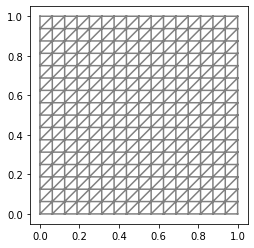

In [141]:
#Run coastal from scratch
#determine spectral domain
y_min=0 #smallest rad. frequency (needs to be larger than 0)
y_max = 1 #largest rad. frequency
x_min=0
x_max = 1
n_x = n_y = 16 #number of elements in frequncy which is dimension no. 0   




#use above info to construct domain, for now keep mesh1 as name.
#is keyword for the source functions
mesh1=RectangleMesh(Point(x_min,y_min),Point(x_max,y_max),n_x,n_y)


T=5.0
num_steps=1000
dt=T/num_steps
t=0

#we want to assign dof to a fenics function
#convert numpy vector into fenics variable
cx=Expression('sqrt(1+pow(x[0],2) + pow(x[1],2) )', degree=4,domain=mesh1)
B=Expression('exp(t)*sin(c*pi*x[0])*sin(c*pi*x[1])',c=cx, degree=4, t=t,domain=mesh1)
cxB=Expression('cx*B',cx=cx,B=B,degree=4,domain=mesh1)




#F=gen_weakform(mesh1,WeakForm,'Implicit_Euler',V,u_n,c,dt,S=S,p_degree=4)
print('CFL no. = ', sqrt(3)*dt/(1/n_x))
plot(mesh1)

In [142]:
#attempt to figure out b.c.
def incoming_boundary(x,on_boundary):
    
    return on_boundary and (near(x[2],0, 1e-14))

def other_boundary(x,on_boundary):
    
    return on_boundary and not (near(x[2],0, 1e-14))


def whole_boundary(x,on_boundary):
    return on_boundary

In [143]:
#Input list of weak forms to test
#Options are LSQ, Galerkin (DG), SUPG
Weak_Tests=['LSQ','Galerkin','SUPG']
#Weak_Tests=['SUPG']
#Input list of time step options 'Implicit Euler', length must agree with weakform length
TimeSteps=['Implicit_Euler', 'Implicit_Euler', 'Implicit_Euler']
#TimeSteps=['Implicit_Euler']
#select degree/type of basis function (Galerkin must be DG)
p_types = ['CG','DG','CG']
#p_types=['P']
pq_degree = [4,4,4]
#pq_degree=[2]
#select time step (type a string either Implicit_Euler, Explicit_Euler, or Trap_Rule)
#create basis functions


# Define variational spaces


error=np.zeros((num_steps,len(Weak_Tests)))
l2_err_vec=np.zeros((num_steps,len(Weak_Tests)))
#need to define it each time if you run due to some kind of scope issue

a=0
for WeakForm in Weak_Tests:

    B.t=0
    V = FunctionSpace(mesh1, p_types[a] , pq_degree[a])
    S=Function(V)
    S=B+cxB.dx(0)+cxB.dx(1)
    C_X=Function(V)
    C_X=interpolate(cx,V)
    C_Y=C_X
    c= as_vector([C_X,C_Y])
    
    #build weakform
    F,bc,u_n=gen_weakform(mesh1,WeakForm,TimeSteps[a],V,B,dt,c,boundary=whole_boundary,S = S,p_degree=4)
    #run simulation
    error[:,a],l2_err_vec[:,a],u=run_sim(num_steps,dt,F,B,bc,u_n,V,mesh)
    a=a+1


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points


148.301161604


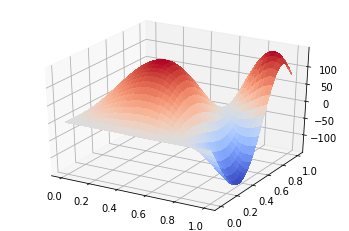

In [144]:
B.t=num_steps*dt
u_e=B
u_e=interpolate(u_e,V)
Out_vec=u_e.vector()[:]#exact
#Out_vec=u.vector()[:]



#get mesh coordinates
n=V.dim()
d=mesh1.geometry().dim()
dof_coordinates=np.zeros((n,d))
dof_x=np.array(interpolate(Expression('x[0]',degree=1),V).vector())
dof_y=np.array(interpolate(Expression('x[1]',degree=1),V).vector())
dof_coordinates[:,0]=dof_x
dof_coordinates[:,1]=dof_y

Matrix_indeces=dof_2_meshgrid_indeces(dof_coordinates)
X=indeces_to_meshgrid(dof_x,Matrix_indeces)
Y=indeces_to_meshgrid(dof_y,Matrix_indeces)
Plot_out=indeces_to_meshgrid(Out_vec,Matrix_indeces)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Plot_out, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
print(np.amax(Plot_out))

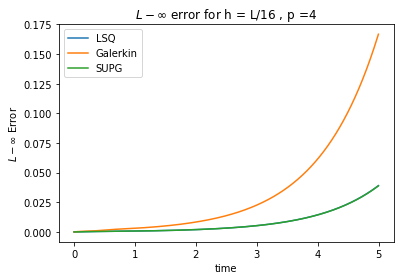

Text(0, 0.5, 'L-2 error')

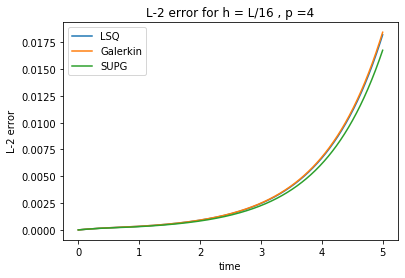

In [145]:
#post-processing in this block
plt.plot(np.array(range(num_steps))*dt,error)
plt.legend(Weak_Tests)
plt.title('$L-\infty$ error for h = L/'+ str(n_x)+" , p ="+str(pq_degree[0]) )
plt.xlabel('time')
plt.ylabel('$L-\infty$ Error')
#plt.savefig("l_infty_error_non_divergence_free_test_h_L_"+str(n_x)+"p_"+str(pq_degree[0])+".png")
plt.show()
plt.plot(np.array(range(num_steps))*dt,l2_err_vec)
plt.legend(Weak_Tests)
plt.title('L-2 error for h = L/'+ str(n_x) +" , p ="+str(pq_degree[0]))
plt.xlabel('time')
plt.ylabel('L-2 error')
#plt.savefig("l_2_error_non_divergence_free_test_h_L_"+str(n_x)+"p_"+str(pq_degree[0])+".png")
# Hold plot
#interactive()

In [146]:
print('Initial L-inf error')
print(error[0,:])
print('Final L-inf error')
print(error[-1,:])
print('Max L-inf error')
print(np.amax(error,axis=0))
print('Initial L-2 error')
print(l2_err_vec[0,:])
print('Final L-2 error')
print(l2_err_vec[-1,:])
print('Max L-2 error')
print(np.amax(l2_err_vec,axis=0))

Initial L-inf error
[  2.98182700e-06   5.83409373e-06   3.10648304e-06]
Final L-inf error
[ 0.03903569  0.16670653  0.03886373]
Max L-inf error
[ 0.03903569  0.16670653  0.03886373]
Initial L-2 error
[  1.54358378e-06   1.56438504e-06   1.36401199e-06]
Final L-2 error
[ 0.01820028  0.0184335   0.01675452]
Max L-2 error
[ 0.01820028  0.0184335   0.01675452]
